In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
from PIL import Image

In [2]:
class PairedImageDataset(Dataset):
    def __init__(self, root_dir_crumpled, root_dir_plain, transform=None):
        self.crumpled_paths = sorted([os.path.join(root_dir_crumpled, filename) for filename in os.listdir(root_dir_crumpled)])
        self.plain_paths = sorted([os.path.join(root_dir_plain, filename) for filename in os.listdir(root_dir_plain)])
        self.transform = transform

    def __len__(self):
        return min(len(self.crumpled_paths), len(self.plain_paths))

    def __getitem__(self, idx):
        crumpled_image = Image.open(self.crumpled_paths[idx]).convert('RGB')
        plain_image = Image.open(self.plain_paths[idx]).convert('RGB')

        if self.transform:
            crumpled_image = self.transform(crumpled_image)
            plain_image = self.transform(plain_image)

        return crumpled_image, plain_image

In [19]:
class ModifiedStyleGAN(nn.Module):
    def __init__(self, image_channels=3):
        ####### debugging
        super(ModifiedStyleGAN, self).__init__()
        # Define the modified StyleGAN architecture to learn the difference between pairs of images
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        print(self.encoder)
        print(self.decoder)
        

    def forward(self, crumpled_image, plain_image):
        # Implement the forward pass to generate the difference (delta) between the images
        # Inside the forward method of ModifiedStyleGAN
        print(f"Crumpled image shape: {crumpled_image.shape}")
        print(f"Plain image shape: {plain_image.shape}")
        combined_input = torch.cat((crumpled_image, plain_image), dim=1)
        encoded_output = self.encoder(combined_input)
        decoded_output = self.decoder(encoded_output)
        delta = decoded_output - plain_image  # Compute the difference (delta) between the generated image and the plain image
        return delta

In [10]:
batch_size=64
transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=Image.BILINEAR),  # Use bilinear interpolation
    transforms.ToTensor(),
])

dataset = PairedImageDataset(root_dir_crumpled='/kaggle/input/crumpledpaper', root_dir_plain='/kaggle/input/plainpaper', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

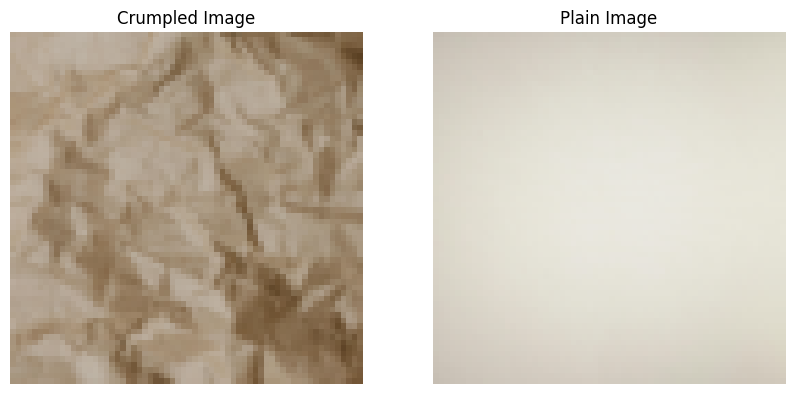

In [12]:
import matplotlib.pyplot as plt

sample_crumpled_image, sample_plain_image = dataset[4]
sample_crumpled_image_np = sample_crumpled_image.permute(1, 2, 0).numpy()
sample_plain_image_np = sample_plain_image.permute(1, 2, 0).numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_crumpled_image_np)
axes[0].set_title('Crumpled Image')
axes[0].axis('off')
axes[1].imshow(sample_plain_image_np)
axes[1].set_title('Plain Image')
axes[1].axis('off')
plt.show()

In [20]:
model = ModifiedStyleGAN().cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
)
Sequential(
  (0): ConvTranspose2d(1024

In [14]:
num_epochs = 10
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        crumpled_images, plain_images = data
        crumpled_images = crumpled_images.cuda()
        plain_images = plain_images.cuda()

        optimizer.zero_grad()
        delta = model(crumpled_images, plain_images)
        loss = criterion(delta, plain_images - crumpled_images)  # Compare the generated delta with the actual difference
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}')

# Save the trained model
torch.save(model.state_dict(), 'modified_stylegan.pth')

Crumpled image shape: torch.Size([6, 3, 64, 64])
Plain image shape: torch.Size([6, 3, 64, 64])


RuntimeError: Given groups=1, weight of size [64, 3, 4, 4], expected input[6, 6, 64, 64] to have 3 channels, but got 6 channels instead

NameError: name 'crumpled_image' is not defined